In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from matplotlib.pylab import rcParams
from statsmodels.tsa.stattools import adfuller


In [10]:
def plot_rolling_statistics(timeseries, window=12):
    
    rolmean = timeseries.rolling(window=window).mean()  # 이동평균 시계열
    rolstd = timeseries.rolling(window=window).std()    # 이동표준편차 시계열

     # 원본시계열, 이동평균, 이동표준편차를 plot으로 시각화해 본다.
    orig = plt.plot(timeseries, color='blue',label='Original')    
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)


def augmented_dickey_fuller_test(timeseries):
    # statsmodels 패키지에서 제공하는 adfuller 메소드를 호출합니다.
    dftest = adfuller(timeseries, autolag='AIC')  
    
    # adfuller 메소드가 리턴한 결과를 정리하여 출력합니다.
    print('Results of Dickey-Fuller Test:')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

In [4]:
dataset_filepath = os.getenv('HOME')+'/aiffel/stock_prediction/data/005930.KS.csv' 
ts = pd.read_csv(dataset_filepath, index_col='Date', parse_dates=True)['Close']
print(type(ts))
ts.head(20)

<class 'pandas.core.series.Series'>


Date
2000-01-04    6110.0
2000-01-05    5580.0
2000-01-06    5620.0
2000-01-07    5540.0
2000-01-10    5770.0
2000-01-11    5770.0
2000-01-12    5720.0
2000-01-13    5710.0
2000-01-14    5830.0
2000-01-17    6100.0
2000-01-18    6100.0
2000-01-19    5960.0
2000-01-20    6040.0
2000-01-21    5880.0
2000-01-24    5700.0
2000-01-25    5440.0
2000-01-26    5480.0
2000-01-27    5520.0
2000-01-28    5820.0
2000-01-31    5580.0
Name: Close, dtype: float64

In [5]:
ts=ts.interpolate(method='time')
ts[ts.isna()]  # Time Series에서 결측치가 있는 부분만 Series로 출력합니다.

Series([], Name: Close, dtype: float64)

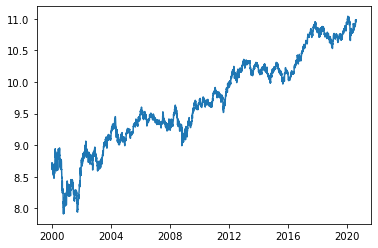

In [6]:
ts_log = np.log(ts)
plt.plot(ts_log)

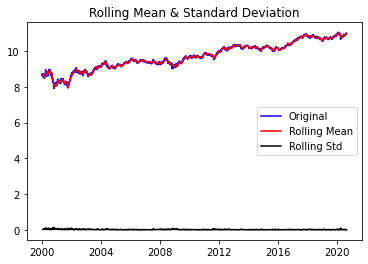

Results of Dickey-Fuller Test:
Test Statistic                   -0.687281
p-value                           0.850017
#Lags Used                        4.000000
Number of Observations Used    5182.000000
Critical Value (1%)              -3.431613
Critical Value (5%)              -2.862098
Critical Value (10%)             -2.567067
dtype: float64


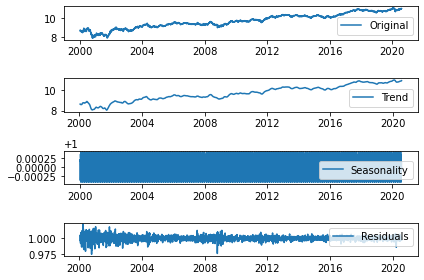

In [13]:
# 정성적 그래프 분석
plot_rolling_statistics(ts_log, window=12)

#정량적 Augmented Dicky-Fuller Test
augmented_dickey_fuller_test(ts_log)

#시계열 분해 (Time Series Decomposition)
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_log, model='multiplicative', period = 30) 

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

In [14]:
residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)

Results of Dickey-Fuller Test:
Test Statistic                -1.728531e+01
p-value                        5.748537e-30
#Lags Used                     3.300000e+01
Number of Observations Used    5.123000e+03
Critical Value (1%)           -3.431627e+00
Critical Value (5%)           -2.862104e+00
Critical Value (10%)          -2.567070e+00
dtype: float64


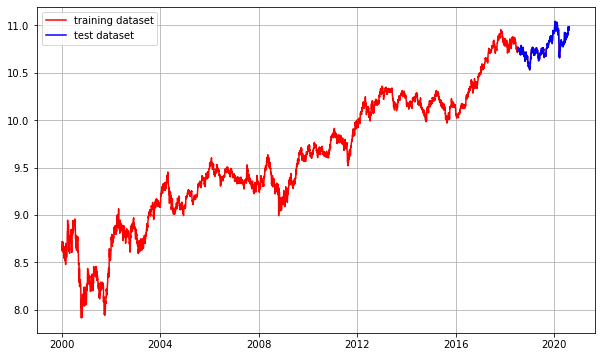

In [15]:
train_data, test_data = ts_log[:int(len(ts_log)*0.9)], ts_log[int(len(ts_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(ts_log, c='r', label='training dataset')  # train_data를 적용하면 그래프가 끊어져 보이므로 자연스러운 연출을 위해 ts_log를 선택
plt.plot(test_data, c='b', label='test dataset')
plt.legend()

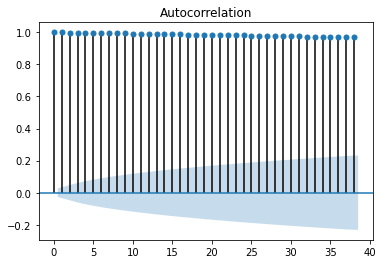

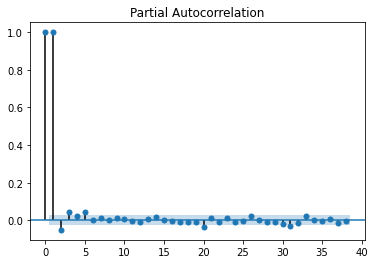

In [16]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(ts_log)   # ACF : Autocorrelation 그래프 그리기
plot_pacf(ts_log)  # PACF : Partial Autocorrelation 그래프 그리기
plt.show()

Results of Dickey-Fuller Test:
Test Statistic                  -39.817874
p-value                           0.000000
#Lags Used                        3.000000
Number of Observations Used    5182.000000
Critical Value (1%)              -3.431613
Critical Value (5%)              -2.862098
Critical Value (10%)             -2.567067
dtype: float64
Results of Dickey-Fuller Test:
Test Statistic                  -21.584636
p-value                           0.000000
#Lags Used                       33.000000
Number of Observations Used    5151.000000
Critical Value (1%)              -3.431620
Critical Value (5%)              -2.862101
Critical Value (10%)             -2.567069
dtype: float64


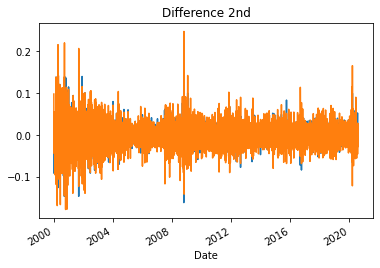

In [17]:
# 1차 차분 구하기
diff_1 = ts_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1)

# 혹시 필요한 경우 2차 차분 구하기
diff_2 = diff_1.diff(periods=1).iloc[1:]
diff_2.plot(title='Difference 2nd')

augmented_dickey_fuller_test(diff_2)

In [18]:
from statsmodels.tsa.arima_model import ARIMA

# Build Model
model = ARIMA(train_data, order=(1, 1, 0))  
fitted_m = model.fit(disp=-1)  
print(fitted_m.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.Close   No. Observations:                 4667
Model:                 ARIMA(1, 1, 0)   Log Likelihood               10983.285
Method:                       css-mle   S.D. of innovations              0.023
Date:                Thu, 13 Aug 2020   AIC                         -21960.569
Time:                        18:08:51   BIC                         -21941.224
Sample:                             1   HQIC                        -21953.765
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0004      0.000      1.205      0.228      -0.000       0.001
ar.L1.D.Close     0.0478      0.015      3.262      0.001       0.019       0.076
                                    Root

/home/aiffel0042/anaconda3/envs/aiffel/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/aiffel0042/anaconda3/envs/aiffel/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


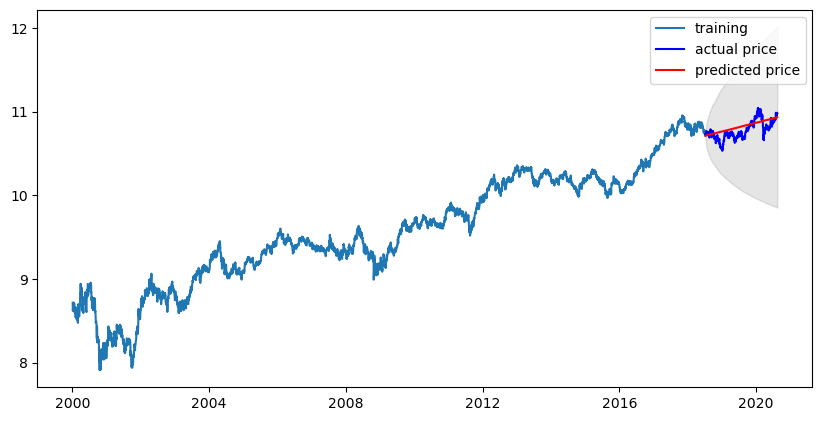

In [19]:
# Forecast : 결과가 fc에 담깁니다. 
fc, se, conf = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과
lower_series = pd.Series(conf[:, 0], index=test_data.index)  # 예측결과의 하한 바운드
upper_series = pd.Series(conf[:, 1], index=test_data.index)  # 예측결과의 상한 바운드

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.10)
plt.legend()
plt.show()

In [20]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  18517858.63179965
MAE:  3590.190001880987
RMSE:  4303.238156528134
MAPE: 7.68%
